In [1]:
import os 
cwd = os.getcwd()

os.chdir('../')
cwd = os.getcwd()
print(cwd)

os.chdir('./code/')
cwd = os.getcwd()
print(cwd)

import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.metrics import  roc_auc_score

import pickle 
import logging


# from config.config import SQLQuery
# querySno = SQLQuery('snowflake')

/Users/shashankgupta/Documents/code/git_project/plaid_credit
/Users/shashankgupta/Documents/code/git_project/plaid_credit/Code


In [2]:
from preprocess import Convert,MissingValues,Outlier,FeatureSelection
from feature_transformation import Scaler,Transform,Selection
from model_building import split_test_train, feature_encoding, classification_models
from model_evaluations import model_metrics, feature_importance, probability_bins, cross_validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

from statsmodels.stats.outliers_influence import variance_inflation_factor

# object initiation 
tf = Transform()
sel = Selection()
ft = FeatureSelection()
cv = Convert()
mv = MissingValues()
ot = Outlier()

# set seed
seed = 37

In [3]:
corr_arr = 0.4 # person correlation coefficient # change it to 0.5
vif_arr = 5 # vif coefficient
features_arr = 10 # total number of features to be selected from backward feature selection
iv_upper_limit = 0.5 # upper threshold of iv # change it to 0.6
iv_lower_limit = 0.02 # lower threshold of iv

In [4]:
df_raw = pd.read_pickle('/Users/shashankgupta/Documents/code/git_project/plaid_credit/data/final_dataset_2.pkl')
df_raw.shape

(646, 255)

In [5]:
df_raw['txn_flag'].value_counts()

txn_flag
1.0    637
0.0      9
Name: count, dtype: int64

In [6]:
df_raw = df_raw[df_raw['txn_flag']==1]
df_raw.shape

(637, 255)

In [7]:
df_raw = df_raw.drop(['business_id', 'lending_business_id','decision_date','drawn_flag', 'everDPD_15', 'fico_score','txn_flag'], axis=1)
df_raw.shape

(637, 248)

In [8]:
## train-test split

# train test split
x_train, y_train, x_test, y_test = split_test_train(df_raw, target_column='target', test_size=0.3, random_state=seed)
print(f'{x_train.shape = }', '|' ,f'{y_train.shape = }', '|' ,f'{x_test.shape = }', '|' ,f'{y_test.shape = }')


# copy to df
df = x_train.copy(deep=True)

x_train.shape = (445, 247) | y_train.shape = (445,) | x_test.shape = (192, 247) | y_test.shape = (192,)


In [9]:
# Treating missing values
df = df.fillna(0)

In [10]:
ind = 0

#replacing 'stddev_credit_amt_3M' with 'credit_size_3M' for business explainability, (correlation coeff is 0.95)

feat_list = ['credit_size_3M',
 'pos_size_1M',
 'ratio_amt_credits_less_100_credits_grt_500_3M',
 'median_credit_amt_1M',
 'ratio_pos_size_1M_6M',
 'median_pos_amt_3M',
 'count_credits_grt_500_3M',
 'loans_size_6M',
 'ach_count_6M']

df['target'] = df_raw['target']

In [11]:
## optimal binning woe

import optbinning as optb
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.binning.binning_statistics import BinningTable

df_temp = df.copy()
df_temp['target'] = df['target']
df_temp = df_temp.fillna(0)

(CVXPY) Jul 03 02:55:03 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 03 02:55:03 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


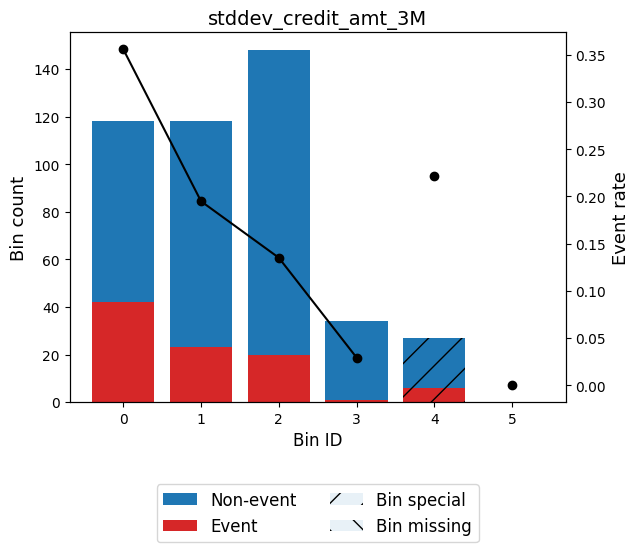

In [12]:
# 1
Xt= df_temp['stddev_credit_amt_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='stddev_credit_amt_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_stddev_credit_amt_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [13]:
ob_stddev_credit_amt_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 563.26)",118,0.265169,76,42,0.355932,-0.751616,0.181308,0.022145
1,"[563.26, 1313.72)",118,0.265169,95,23,0.194915,0.073703,0.001409,0.000176
2,"[1313.72, 7591.32)",148,0.332584,128,20,0.135135,0.511619,0.074295,0.009187
3,"[7591.32, inf)",34,0.076404,33,1,0.029412,2.151828,0.177773,0.018732
4,Special,27,0.060674,21,6,0.222222,-0.091917,0.000526,0.000066
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.435311,0.050306


In [14]:
# 1
# Var tranform
transformed_vars = df.copy()

# transform
col         = 'stddev_credit_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 578), 
                (transformed_vars[col] >= 578 ) & (transformed_vars[col] < 1274), 
                (transformed_vars[col] >= 1274) & (transformed_vars[col] < 7646),
                transformed_vars[col] >= 7646 ]

choices     = [0.090405,-0.551449,-0.013445, 0.40452,1.951157]
    
transformed_vars["stddev_credit_amt_3M"] = np.select(conditions, choices, default=np.nan)

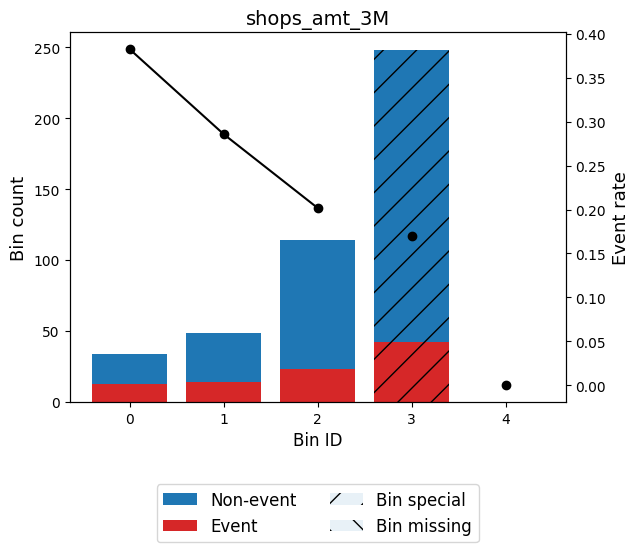

In [15]:
# 2
Xt= df_temp['shops_amt_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='shops_amt_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_shops_amt_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [16]:
ob_shops_amt_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 109.53)",34,0.076404,21,13,0.382353,-0.865106,0.070778,0.008581
1,"[109.53, 848.23)",49,0.110112,35,14,0.285714,-0.428389,0.022715,0.002818
2,"[848.23, inf)",114,0.256180,91,23,0.201754,0.030686,0.000239,0.000030
3,Special,248,0.557303,206,42,0.169355,0.245527,0.031194,0.003889
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.124926,0.015318


In [17]:
df_temp['shops_amt_3M']

566     341.32
262      27.91
202       0.25
525       0.00
335       0.00
        ...   
141     700.00
85      127.03
523       0.00
161       0.00
314    1039.97
Name: shops_amt_3M, Length: 445, dtype: float64

In [18]:
# 2
# transform
col         = 'shops_amt_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 221.5), 
                (transformed_vars[col] >= 221.5 ) & (transformed_vars[col] < 2588), 
                transformed_vars[col] >= 2588 ]

choices     = [0.226839,-0.738544,-0.408586,0.38456]
    
transformed_vars["shops_amt_3M"] = np.select(conditions, choices, default=np.nan)

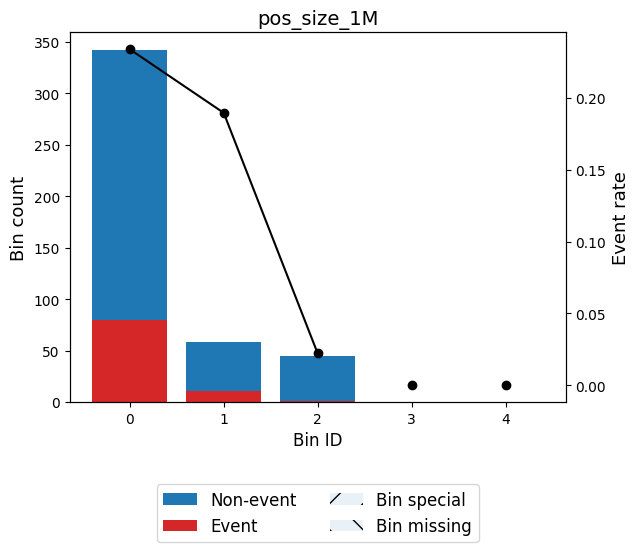

In [19]:
# 3
Xt= df_temp['pos_size_1M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='pos_size_1M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_pos_size_1M= optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [20]:
ob_pos_size_1M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 232.19)",342,0.768539,262,80,0.233918,-0.158362,0.020168,0.002518
1,"[232.19, 908.25)",58,0.130337,47,11,0.189655,0.107573,0.001461,0.000183
2,"[908.25, inf)",45,0.101124,44,1,0.022222,2.43951,0.277559,0.028043
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.299188,0.030744


In [21]:
# 3
# transform
col         = 'pos_size_1M'
conditions  = [ transformed_vars[col] < 235.11, 
                (transformed_vars[col] >= 235.11 ) & (transformed_vars[col] < 979.44), 
                transformed_vars[col] >= 979.44 ]

choices     = [-0.152312,0.159398,1.699843]
    
transformed_vars["pos_size_1M"] = np.select(conditions, choices, default=np.nan)

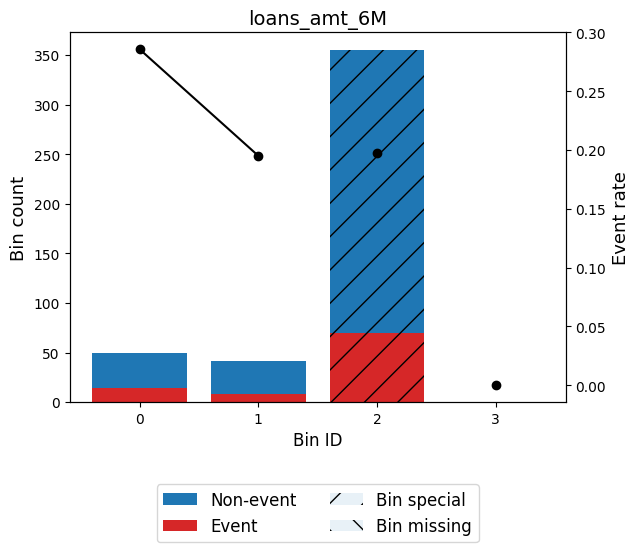

In [22]:
# 4
Xt= df_temp['loans_amt_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='loans_amt_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_loans_amt_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [23]:
ob_loans_amt_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6905.79)",49,0.110112,35,14,0.285714,-0.428389,0.022715,0.002818
1,"[6905.79, inf)",41,0.092135,33,8,0.195122,0.072387,0.000473,0.000059
2,Special,355,0.797753,285,70,0.197183,0.059314,0.002758,0.000345
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.025945,0.003222


In [24]:
# 4
# transform
col         = 'loans_amt_6M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 21503),
                transformed_vars[col] >= 21503 ]

choices     = [0.08126,-0.518001,0.647751]
    
transformed_vars["loans_amt_6M"] = np.select(conditions, choices, default=np.nan)

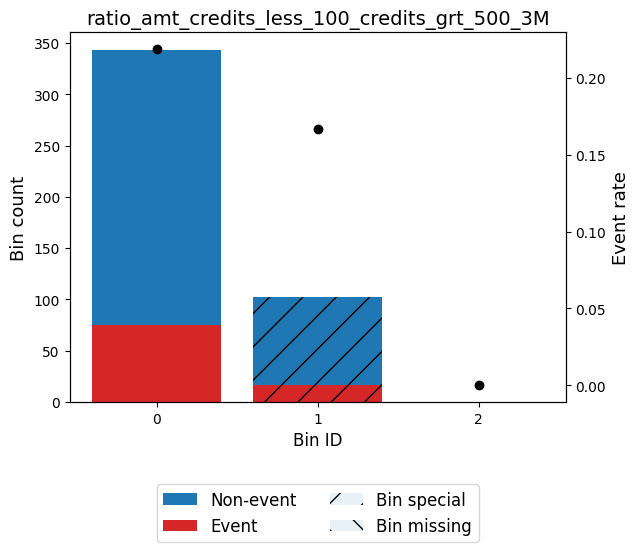

In [105]:
# 5
Xt= df_temp['ratio_amt_credits_less_100_credits_grt_500_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_amt_credits_less_100_credits_grt_500_3M', dtype="numerical", max_n_prebins=2, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_amt_credits_less_100_credits_grt_500_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [106]:
ob_ratio_amt_credits_less_100_credits_grt_500_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",343,0.770787,268,75,0.218659,-0.071181,0.003987,0.000498
1,Special,102,0.229213,85,17,0.166667,0.264758,0.014829,0.001848
2,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.018816,0.002347


In [27]:
# 5
# transform
col         = 'ratio_amt_credits_less_100_credits_grt_500_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [-0.112536,0.045514]
    
transformed_vars["ratio_amt_credits_less_100_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

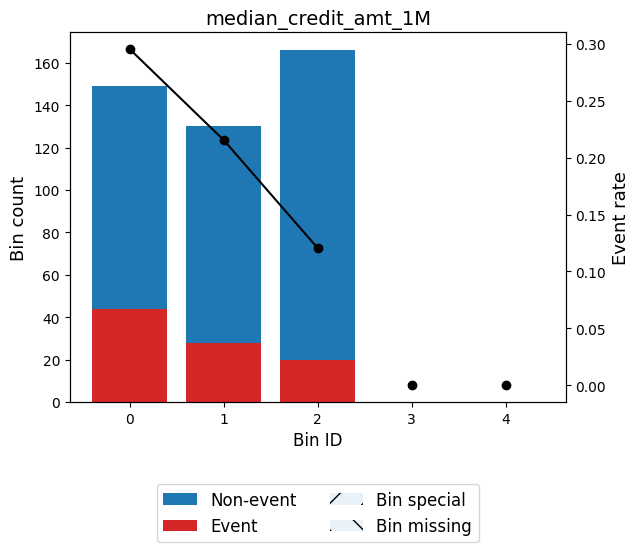

In [28]:
# 6
Xt= df_temp['median_credit_amt_1M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='median_credit_amt_1M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_median_credit_amt_1M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [29]:
ob_median_credit_amt_1M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 120.83)",149,0.334831,105,44,0.295302,-0.474909,0.085868,0.010634
1,"[120.83, 506.44)",130,0.292135,102,28,0.215385,-0.051911,0.000799,0.000100
2,"[506.44, inf)",166,0.373034,146,20,0.120482,0.643195,0.126199,0.015508
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.212867,0.026242


In [30]:
# 6
# transform
col         = 'median_credit_amt_1M'
conditions  = [ transformed_vars[col] < 102,
                (transformed_vars[col] >= 102 ) & (transformed_vars[col] < 475.2),
                transformed_vars[col] >= 475.2 ]

choices     = [-0.444738,-0.119068,0.550264]
    
transformed_vars["median_credit_amt_1M"] = np.select(conditions, choices, default=np.nan)

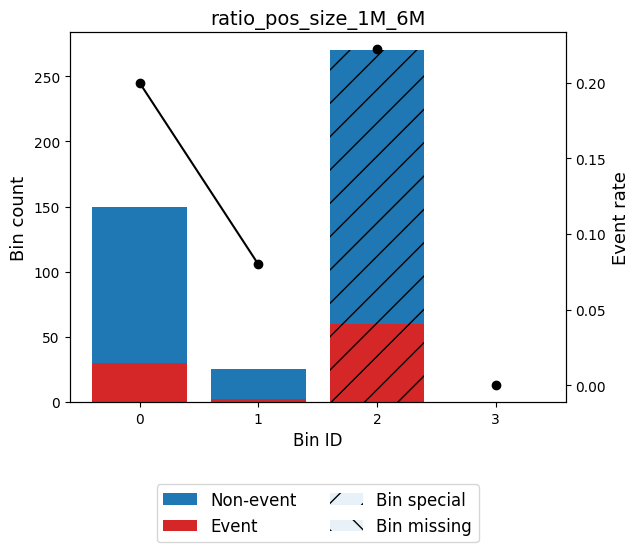

In [31]:
# 7
Xt= df_temp['ratio_pos_size_1M_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_pos_size_1M_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_pos_size_1M_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [32]:
ob_ratio_pos_size_1M_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.21)",150,0.337079,120,30,0.200000,0.041615,0.000577,0.000072
1,"[1.21, inf)",25,0.056180,23,2,0.080000,1.097668,0.047657,0.005675
2,Special,270,0.606742,210,60,0.222222,-0.091917,0.005264,0.000658
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.053498,0.006405


In [33]:
# 7
# transform
col         = 'ratio_pos_size_1M_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 1.21),
                transformed_vars[col] >= 1.21 ]

choices     = [-0.164722,0.141314,1.140227]
    
transformed_vars["ratio_pos_size_1M_6M"] = np.select(conditions, choices, default=np.nan)

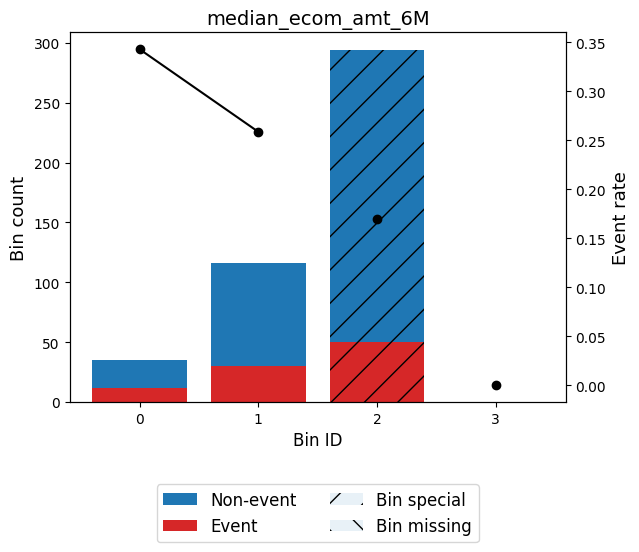

In [34]:
# 8
Xt= df_temp['median_ecom_amt_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='median_ecom_amt_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending', special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_median_ecom_amt_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [35]:
ob_median_ecom_amt_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 15.53)",35,0.078652,23,12,0.342857,-0.694092,0.045310,0.005553
1,"[15.53, inf)",116,0.260674,86,30,0.258621,-0.29153,0.024040,0.002994
2,Special,294,0.660674,244,50,0.170068,0.240466,0.035526,0.004430
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.104876,0.012977


In [36]:
# 8
# transform
col         = 'median_ecom_amt_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 49.74),
                transformed_vars[col] >= 49.74 ]

choices     = [0.30558,-0.576309,-0.303226]
    
transformed_vars["median_ecom_amt_6M"] = np.select(conditions, choices, default=np.nan)

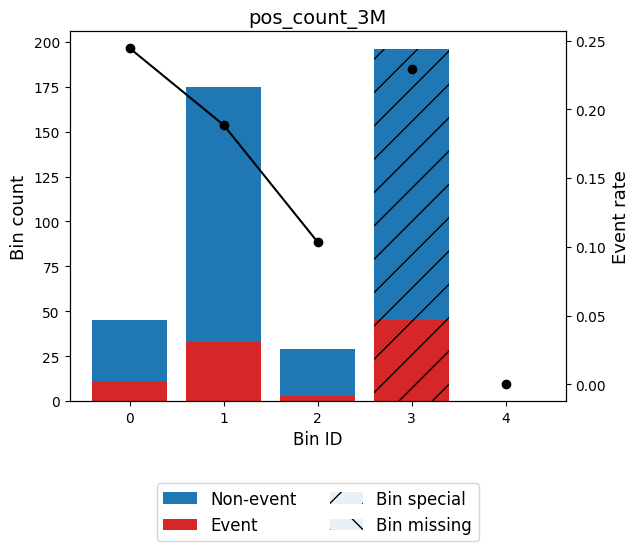

In [37]:
# 9
Xt= df_temp['pos_count_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='pos_count_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending', special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_pos_count_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [38]:
ob_pos_count_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",45,0.101124,34,11,0.244444,-0.216214,0.005027,0.000627
1,"[1.50, 14.50)",175,0.393258,142,33,0.188571,0.11464,0.004995,0.000624
2,"[14.50, inf)",29,0.065169,26,3,0.103448,0.814805,0.033444,0.004069
3,Special,196,0.440449,151,45,0.229592,-0.134062,0.008227,0.001028
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.051693,0.006347


In [39]:
# 9
# transform
col         = 'pos_count_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [-0.25334,0.201958]
    
transformed_vars["pos_count_3M"] = np.select(conditions, choices, default=np.nan)

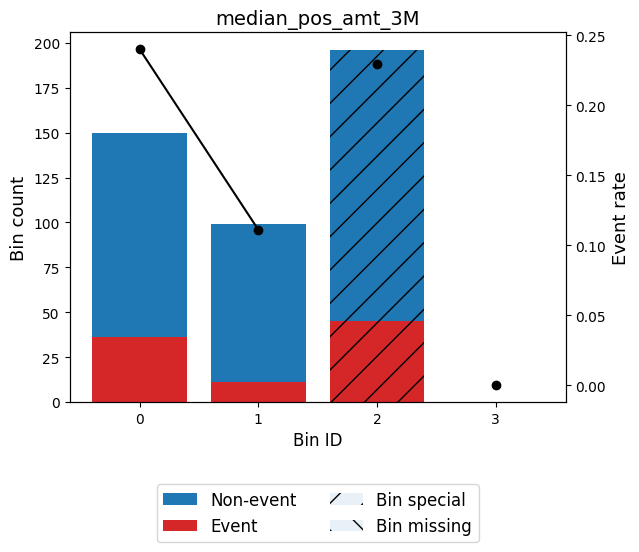

In [40]:
# 10
Xt= df_temp['median_pos_amt_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='median_pos_amt_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_median_pos_amt_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [41]:
ob_median_pos_amt_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 486.25)",150,0.337079,114,36,0.240000,-0.192,0.013125,0.001638
1,"[486.25, inf)",99,0.222472,88,11,0.111111,0.734762,0.095318,0.011654
2,Special,196,0.440449,151,45,0.229592,-0.134062,0.008227,0.001028
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.116670,0.014319


In [42]:
# 10
# transform
col         = 'median_pos_amt_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 486.25),
                transformed_vars[col] >= 486.25 ]

choices     = [-0.25334,-0.127284,0.968955]
    
transformed_vars["median_pos_amt_3M"] = np.select(conditions, choices, default=np.nan)

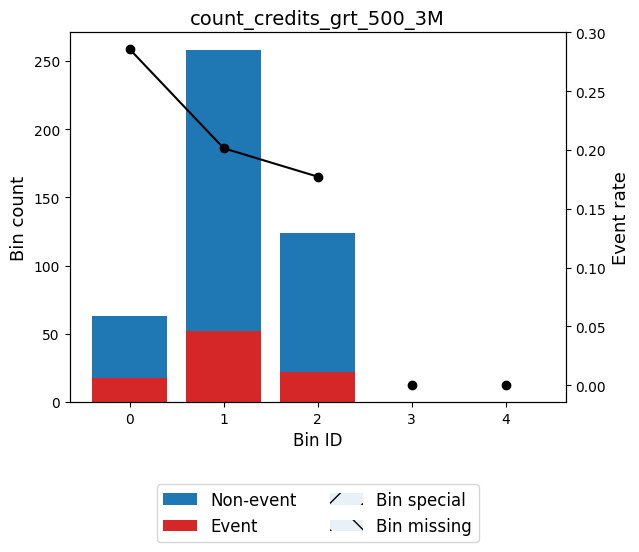

In [43]:
# 11
Xt= df_temp['count_credits_grt_500_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='count_credits_grt_500_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_count_credits_grt_500_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [44]:
ob_count_credits_grt_500_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",63,0.141573,45,18,0.285714,-0.428389,0.029205,0.003623
1,"[1.50, 15.50)",258,0.579775,206,52,0.201550,0.031953,0.000586,0.000073
2,"[15.50, inf)",124,0.278652,102,22,0.177419,0.189251,0.009429,0.001177
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.039220,0.004873


In [45]:
# 11
# transform
col         = 'count_credits_grt_500_3M'
conditions  = [ transformed_vars[col] < 1.5,
                (transformed_vars[col] >= 1.5 ) & (transformed_vars[col] < 15.5),
                transformed_vars[col] >= 15.5 ]

choices     = [-0.450862,-0.000945,0.284561]
    
transformed_vars["count_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

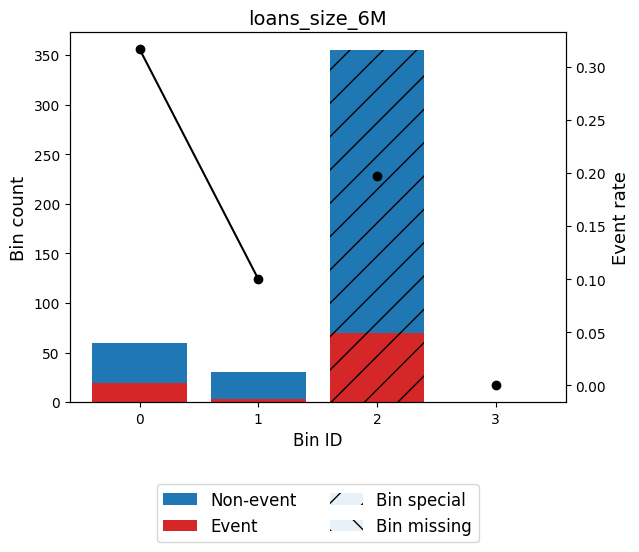

In [46]:
# 12
Xt= df_temp['loans_size_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='loans_size_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_loans_size_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [47]:
ob_loans_size_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3316.67)",60,0.134831,41,19,0.316667,-0.575546,0.052015,0.006414
1,"[3316.67, inf)",30,0.067416,27,3,0.100000,0.852545,0.037408,0.004539
2,Special,355,0.797753,285,70,0.197183,0.059314,0.002758,0.000345
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.092181,0.011298


In [48]:
# 12
# transform
col         = 'loans_size_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 3317),
                transformed_vars[col] >= 3317 ]

choices     = [0.08126,-0.605012,0.814805]
    
transformed_vars["loans_size_6M"] = np.select(conditions, choices, default=np.nan)

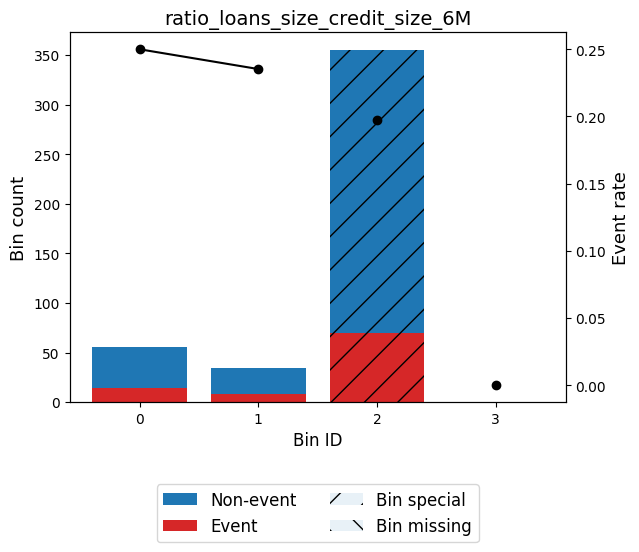

In [49]:
# 13
Xt= df_temp['ratio_loans_size_credit_size_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_loans_size_credit_size_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_loans_size_credit_size_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [50]:
ob_ratio_loans_size_credit_size_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.30)",56,0.125843,42,14,0.250000,-0.246067,0.008168,0.001018
1,"[1.30, inf)",34,0.076404,26,8,0.235294,-0.166024,0.002208,0.000276
2,Special,355,0.797753,285,70,0.197183,0.059314,0.002758,0.000345
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.013134,0.001639


In [51]:
# 13
# transform
col         = 'ratio_loans_size_credit_size_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 1.11),
                transformed_vars[col] >= 1.11 ]

choices     = [0.08126,-0.389168,-0.107917]
    
transformed_vars["ratio_loans_size_credit_size_6M"] = np.select(conditions, choices, default=np.nan)

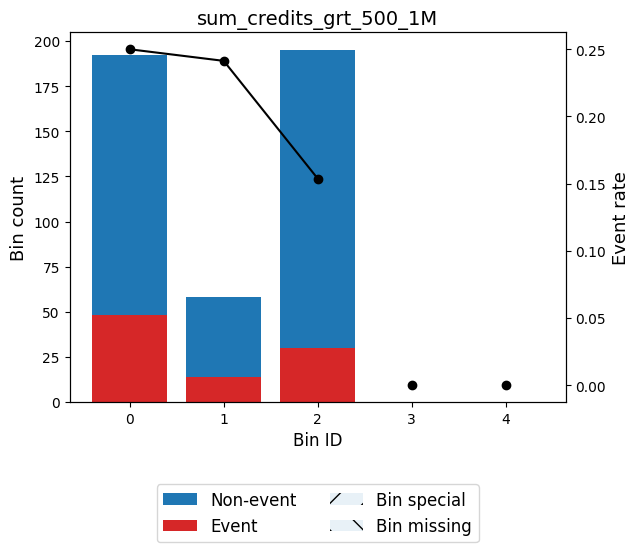

In [52]:
# 14
Xt= df_temp['sum_credits_grt_500_1M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='sum_credits_grt_500_1M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_sum_credits_grt_500_1M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [53]:
ob_sum_credits_grt_500_1M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4255.33)",192,0.431461,144,48,0.250000,-0.246067,0.028004,0.003492
1,"[4255.33, 6586.72)",58,0.130337,44,14,0.241379,-0.199547,0.005493,0.000686
2,"[6586.72, inf)",195,0.438202,165,30,0.153846,0.360069,0.050890,0.006327
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.084388,0.010504


In [54]:
# 14
# transform
col         = 'sum_credits_grt_500_1M'
conditions  = [ transformed_vars[col] < 6587,
                transformed_vars[col] >= 6587 ]

choices     = [-0.246067,0.422079]
    
transformed_vars["sum_credits_grt_500_1M"] = np.select(conditions, choices, default=np.nan)

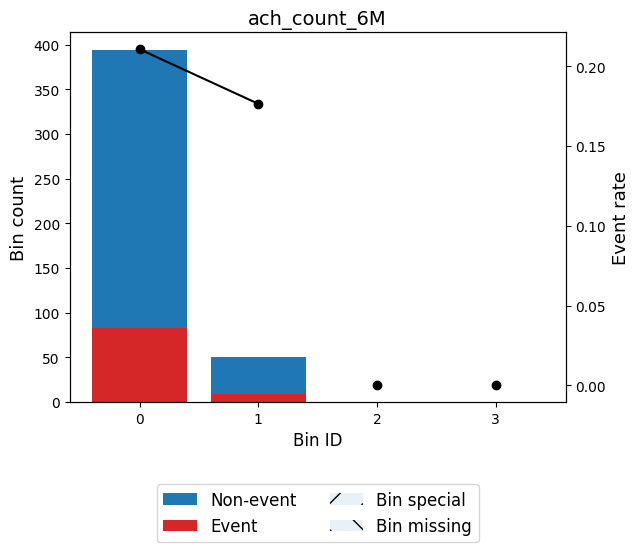

In [55]:
# 15
Xt= df_temp['ach_count_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ach_count_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ach_count_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [56]:
ob_ach_count_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 9.50)",394,0.885393,311,83,0.210660,-0.023727,0.000502,0.000063
1,"[9.50, inf)",51,0.114607,42,9,0.176471,0.195766,0.004141,0.000517
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.004643,0.000580


In [57]:
# 15
# transform
col         = 'ach_count_6M'
conditions  = [ transformed_vars[col] < 6.5,
                transformed_vars[col] >= 6.5 ]

choices     = [-0.022101,0.149246]
    
transformed_vars["ach_count_6M"] = np.select(conditions, choices, default=np.nan)

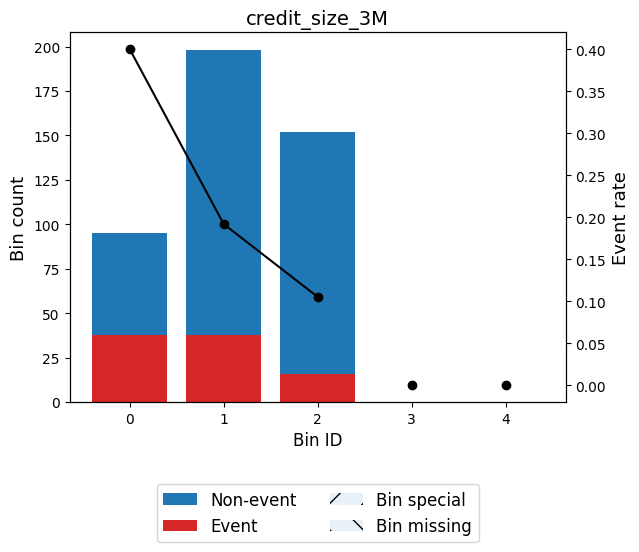

In [58]:
# 16
Xt= df_temp['credit_size_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='credit_size_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_credit_size_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [59]:
ob_credit_size_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 330.75)",95,0.213483,57,38,0.400000,-0.939214,0.236279,0.028495
1,"[330.75, 1240.81)",198,0.444944,160,38,0.191919,0.092908,0.003736,0.000467
2,"[1240.81, inf)",152,0.341573,136,16,0.105263,0.795387,0.168110,0.020477
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.408125,0.049439


In [60]:
# 16
# transform
col         = 'credit_size_3M'
conditions  = [ transformed_vars[col] < 178.8,
                (transformed_vars[col] >= 178.9 ) & (transformed_vars[col] < 392.56),
                (transformed_vars[col] >= 392.56 ) & (transformed_vars[col] < 2274.8),
                transformed_vars[col] >= 2274.8 ]

choices     = [-1.056997,-0.484478,0.184337,1.294378]
    
transformed_vars["credit_size_3M"] = np.select(conditions, choices, default=np.nan)

#### Model fitting

In [61]:
# copy vars
X_train = transformed_vars.copy()

# hyperparameters
params_log_reg = {'penalty': 'l2',
                  'random_state': seed,
                  'solver': 'liblinear',
                  'class_weight': 'balanced'}

# model fit
logreg_model = classification_models(X_train[feat_list], y_train, params_log_reg, models=['log_reg'])

In [62]:
# train cv scores
cv_scores = cross_validation(logreg_model, X_train[feat_list], y_train, scoring='roc_auc', folds=3, seed=seed)
print('CV Scores -',np.round(cv_scores, 2))
print('Mean of CV Scores -',np.round(np.mean(cv_scores),2))

CV Scores - [0.67 0.67 0.69]
Mean of CV Scores - 0.68


In [63]:
# Feature importance
feat_imp = feature_importance(logreg_model, X_train[feat_list], show_plot=True)

feat_imp.sort_values(by='importance', ascending=False)

,importance
count_credits_grt_500_3M,0.865652
ratio_amt_credits_less_100_credits_grt_500_3M,0.723851
ach_count_6M,0.185724
median_pos_amt_3M,-0.126851
median_credit_amt_1M,-0.345177
ratio_pos_size_1M_6M,-0.353188
loans_size_6M,-0.421555
credit_size_3M,-0.819978
pos_size_1M,-0.856859


In [96]:
feat_imp.sort_values(by='importance', ascending=False).to_clipboard()

In [64]:
# binning variable transform
x_test.fillna(0, inplace=True)

transformed_vars = x_test

In [65]:
# 1
# transform
col         = 'stddev_credit_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 578), 
                (transformed_vars[col] >= 578 ) & (transformed_vars[col] < 1274), 
                (transformed_vars[col] >= 1274) & (transformed_vars[col] < 7646),
                transformed_vars[col] >= 7646 ]

choices     = [0.090405,-0.551449,-0.013445, 0.40452,1.951157]
    
transformed_vars["stddev_credit_amt_3M"] = np.select(conditions, choices, default=np.nan)

# 2
# transform
col         = 'shops_amt_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 221.5), 
                (transformed_vars[col] >= 221.5 ) & (transformed_vars[col] < 2588), 
                transformed_vars[col] >= 2588 ]

choices     = [0.226839,-0.738544,-0.408586,0.38456]
    
transformed_vars["shops_amt_3M"] = np.select(conditions, choices, default=np.nan)

# 3
# transform
col         = 'pos_size_1M'
conditions  = [ transformed_vars[col] < 235.11, 
                (transformed_vars[col] >= 235.11 ) & (transformed_vars[col] < 979.44), 
                transformed_vars[col] >= 979.44 ]

choices     = [-0.152312,0.159398,1.699843]
    
transformed_vars["pos_size_1M"] = np.select(conditions, choices, default=np.nan)

# 4
# transform
col         = 'loans_amt_6M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 21503),
                transformed_vars[col] >= 21503 ]

choices     = [0.08126,-0.518001,0.647751]
    
transformed_vars["loans_amt_6M"] = np.select(conditions, choices, default=np.nan)

# 5
# transform
col         = 'ratio_amt_credits_less_100_credits_grt_500_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [-0.112536,0.045514]
    
transformed_vars["ratio_amt_credits_less_100_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

# 6
# transform
col         = 'median_credit_amt_1M'
conditions  = [ transformed_vars[col] < 102,
                (transformed_vars[col] >= 102 ) & (transformed_vars[col] < 475.2),
                transformed_vars[col] >= 475.2 ]

choices     = [-0.444738,-0.119068,0.550264]
    
transformed_vars["median_credit_amt_1M"] = np.select(conditions, choices, default=np.nan)

# 7
# transform
col         = 'ratio_pos_size_1M_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 1.21),
                transformed_vars[col] >= 1.21 ]

choices     = [-0.164722,0.141314,1.140227]
    
transformed_vars["ratio_pos_size_1M_6M"] = np.select(conditions, choices, default=np.nan)

# 8
# transform
col         = 'median_ecom_amt_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 49.74),
                transformed_vars[col] >= 49.74 ]

choices     = [0.30558,-0.576309,-0.303226]
    
transformed_vars["median_ecom_amt_6M"] = np.select(conditions, choices, default=np.nan)

# 9
# transform
col         = 'pos_count_3M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [-0.25334,0.201958]
    
transformed_vars["pos_count_3M"] = np.select(conditions, choices, default=np.nan)

# 10
# transform
col         = 'median_pos_amt_3M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 486.25),
                transformed_vars[col] >= 486.25 ]

choices     = [-0.25334,-0.127284,0.968955]
    
transformed_vars["median_pos_amt_3M"] = np.select(conditions, choices, default=np.nan)

# 11
# transform
col         = 'count_credits_grt_500_3M'
conditions  = [ transformed_vars[col] < 1.5,
                (transformed_vars[col] >= 1.5 ) & (transformed_vars[col] < 15.5),
                transformed_vars[col] >= 15.5 ]

choices     = [-0.450862,-0.000945,0.284561]
    
transformed_vars["count_credits_grt_500_3M"] = np.select(conditions, choices, default=np.nan)

# 12
# transform
col         = 'loans_size_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 3317),
                transformed_vars[col] >= 3317 ]

choices     = [0.08126,-0.605012,0.814805]
    
transformed_vars["loans_size_6M"] = np.select(conditions, choices, default=np.nan)

# 13
# transform
col         = 'ratio_loans_size_credit_size_6M'
conditions  = [ transformed_vars[col] <= 0,
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 1.11),
                transformed_vars[col] >= 1.11 ]

choices     = [0.08126,-0.389168,-0.107917]
    
transformed_vars["ratio_loans_size_credit_size_6M"] = np.select(conditions, choices, default=np.nan)

# 14
# transform
col         = 'sum_credits_grt_500_1M'
conditions  = [ transformed_vars[col] < 6587,
                transformed_vars[col] >= 6587 ]

choices     = [-0.246067,0.422079]
    
transformed_vars["sum_credits_grt_500_1M"] = np.select(conditions, choices, default=np.nan)

# 15
# transform
col         = 'ach_count_6M'
conditions  = [ transformed_vars[col] < 6.5,
                transformed_vars[col] >= 6.5 ]

choices     = [-0.022101,0.149246]
    
transformed_vars["ach_count_6M"] = np.select(conditions, choices, default=np.nan)

# 16
# transform
col         = 'credit_size_3M'
conditions  = [ transformed_vars[col] < 178.8,
                (transformed_vars[col] >= 178.9 ) & (transformed_vars[col] < 392.56),
                (transformed_vars[col] >= 392.56 ) & (transformed_vars[col] < 2274.8),
                transformed_vars[col] >= 2274.8 ]

choices     = [-1.056997,-0.484478,0.184337,1.294378]
    
transformed_vars["credit_size_3M"] = np.select(conditions, choices, default=np.nan)

In [66]:
# copy
X_test = transformed_vars.copy()

In [67]:
# test cv scores
cv_scores = cross_validation(logreg_model, X_test[feat_list], y_test, scoring='roc_auc', folds=3, seed=seed)
print('CV Scores -',np.round(cv_scores, 2))
print('Mean of CV Scores -',np.round(np.mean(cv_scores),2))

CV Scores - [0.59 0.63 0.54]
Mean of CV Scores - 0.59


In [68]:
## Model Evaluation - KS & ROC AUC

def ks(target=None, prob=None):
    data = pd.DataFrame()
    data['y'] = target
    data['y'] = data['y'].astype(float)
    data['p'] = prob
    data['y0'] = 1- data['y']
    data['bucket'] = pd.qcut(data['p'], 5, duplicates = 'drop')
    grouped = data.groupby('bucket', as_index=False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['p']
    kstable['max_prob'] = grouped.max()['p']
    kstable['events'] = grouped.sum()['y']
    kstable['nonevents'] = grouped.sum()['y0']
    kstable = kstable.sort_values(by='min_prob', ascending=False).reset_index(drop=True)
    kstable['event_rate'] = (kstable.events / data['y'].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable['nonevents'] /  data['y0'].sum()).apply('{0:2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data['y'].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['y0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    kstable['bad_rate'] = (kstable['events'] / (kstable['events'] + kstable['nonevents'])) * 100
    
    # formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    # kstable.index = range(1,len(data['bucket'].unique())+1)
    # kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    # Display KS
    print("KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return kstable

In [69]:
# predicted proability
train_pred = logreg_model.predict_proba(X_train[feat_list])[:,1]
                                                                     
test_pred = logreg_model.predict_proba(X_test[feat_list])[:,1]


train_ks = ks(y_train, train_pred)
test_ks = ks(y_test, test_pred)



   min_prob  max_prob  events  nonevents  ... cum_eventrate cum_noneventrate  \
0  0.631069  0.820957    35.0       47.0  ...        38.04%           13.31%   
1  0.533721  0.628923    22.0       74.0  ...        61.96%           34.28%   
2  0.456239  0.530817    19.0       68.0  ...        82.61%           53.54%   
3  0.264609  0.455167    13.0       78.0  ...        96.74%           75.64%   
4  0.035467  0.261540     3.0       86.0  ...       100.00%          100.00%   

     KS   bad_rate  
0  24.7  42.682927  
1  27.7  22.916667  
2  29.1  21.839080  
3  21.1  14.285714  
4   0.0   3.370787  

[5 rows x 10 columns]
KS is 29.099999999999998% at decile 2
   min_prob  max_prob  events  nonevents  ... cum_eventrate cum_noneventrate  \
0  0.654689  0.801988    17.0       21.0  ...        42.50%           13.82%   
1  0.532905  0.649594     9.0       30.0  ...        65.00%           33.55%   
2  0.472630  0.530325     6.0       31.0  ...        80.00%           53.95%   
3  0.371624 

In [91]:
ks(y_test, test_pred)

   min_prob  max_prob  events  nonevents  ... cum_eventrate cum_noneventrate  \
0  0.654689  0.801988    17.0       21.0  ...        42.50%           13.82%   
1  0.532905  0.649594     9.0       30.0  ...        65.00%           33.55%   
2  0.472630  0.530325     6.0       31.0  ...        80.00%           53.95%   
3  0.371624  0.468100     5.0       32.0  ...        92.50%           75.00%   
4  0.044590  0.341189     3.0       38.0  ...       100.00%          100.00%   

     KS   bad_rate  
0  28.7  44.736842  
1  31.4  23.076923  
2  26.1  16.216216  
3  17.5  13.513514  
4   0.0   7.317073  

[5 rows x 10 columns]
KS is 31.4% at decile 1


,min_prob,max_prob,events,nonevents,...,cum_eventrate,cum_noneventrate,KS,bad_rate
0,0.654689,0.801988,17.0,21.0,...,42.50%,13.82%,28.7,44.736842
1,0.532905,0.649594,9.0,30.0,...,65.00%,33.55%,31.4,23.076923
2,0.472630,0.530325,6.0,31.0,...,80.00%,53.95%,26.1,16.216216
3,0.371624,0.468100,5.0,32.0,...,92.50%,75.00%,17.5,13.513514
4,0.044590,0.341189,3.0,38.0,...,100.00%,100.00%,0.0,7.317073


In [70]:
# AUC scores
print('Train AUC = {}'.format(roc_auc_score(y_train, train_pred)))   
  
print('Test AUC = {}'.format(roc_auc_score(y_test, test_pred)))    

Train AUC = 0.7142967114176624
Test AUC = 0.704358552631579


In [93]:
train_ks

,min_prob,max_prob,events,nonevents,...,cum_eventrate,cum_noneventrate,KS,bad_rate
0,0.631069,0.820957,35.0,47.0,...,38.04%,13.31%,24.7,42.682927
1,0.533721,0.628923,22.0,74.0,...,61.96%,34.28%,27.7,22.916667
2,0.456239,0.530817,19.0,68.0,...,82.61%,53.54%,29.1,21.839080
3,0.264609,0.455167,13.0,78.0,...,96.74%,75.64%,21.1,14.285714
4,0.035467,0.261540,3.0,86.0,...,100.00%,100.00%,0.0,3.370787


In [95]:
test_ks

,min_prob,max_prob,events,nonevents,...,cum_eventrate,cum_noneventrate,KS,bad_rate
0,0.654689,0.801988,17.0,21.0,...,42.50%,13.82%,28.7,44.736842
1,0.532905,0.649594,9.0,30.0,...,65.00%,33.55%,31.4,23.076923
2,0.472630,0.530325,6.0,31.0,...,80.00%,53.95%,26.1,16.216216
3,0.371624,0.468100,5.0,32.0,...,92.50%,75.00%,17.5,13.513514
4,0.044590,0.341189,3.0,38.0,...,100.00%,100.00%,0.0,7.317073


In [115]:
feat_list

['credit_size_3M',
 'pos_size_1M',
 'ratio_amt_credits_less_100_credits_grt_500_3M',
 'median_credit_amt_1M',
 'ratio_pos_size_1M_6M',
 'median_pos_amt_3M',
 'count_credits_grt_500_3M',
 'loans_size_6M',
 'ach_count_6M']

In [75]:
# Scoring on train

train1 = X_train.copy()
train1['pred_proba'] = logreg_model.predict_proba(X_train[feat_list])[:,1]

train1['odds'] = train1['pred_proba'] / (1-train1['pred_proba'])
train1['log_odds'] = np.log(train1['odds'])
train1['risk_score'] = 601.7 - (86.6 * train1['log_odds'])
train1.risk_score.describe()

count    445.000000
mean     620.618276
std       76.922737
min      469.821422
25%      567.703714
50%      603.502434
75%      663.779833
max      887.743320
Name: risk_score, dtype: float64

In [77]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def ml_modelling(model, x_train, x_test, y_train, y_test):

    # model.fit(x_train, y_train)
    
    # threshold tuning
    y_hat = model.predict_proba(x_test)
    y_hat = y_hat[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_hat, pos_label=1)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    
    # predictions
    y_pred1 = model.predict_proba(x_train)
    y_pred2 = model.predict_proba(x_test)
    
    return model, y_pred1, y_pred2, best_thresh

logreg_model, y_hat1, y_hat2, thresh = ml_modelling(logreg_model, X_train[feat_list], X_test[feat_list], y_train.astype(int), y_test.astype(int))

def evaluate_model(y_actual, y_pred, y_hat):
    y_actual = y_actual.astype(y_pred.dtype)
    print(classification_report(y_actual, y_pred))
    print(confusion_matrix(y_actual, y_pred))
    print(roc_auc_score(y_actual, y_hat))

y_pred1 = y_hat1[:,1] >= thresh
y_pred2 = y_hat2[:,1] >= thresh

evaluate_model(y_train.astype(int), y_pred1, y_hat1[:,1])
evaluate_model(y_test.astype(int), y_pred2, y_hat2[:,1])

train_ks_thresh = ks(y_train.astype(int), y_hat1[:,1])
test_ks_thresh= ks(y_test.astype(int), y_hat2[:,1])

## Probability Calibration

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

platt = CalibratedClassifierCV(logreg_model,  method="sigmoid", cv=3)

platt.fit(X_train[feat_list], y_train.astype(int))

# threshold tuning

platt, y_hat3, y_hat4, thresh = ml_modelling(platt, X_train[feat_list], X_test[feat_list], y_train.astype(int), y_test.astype(int))

y_pred3 = y_hat3[:,1] >= thresh
y_pred4 = y_hat4[:,1] >= thresh

evaluate_model(y_train.astype(int), y_pred3, y_hat3[:,1])
evaluate_model(y_test.astype(int), y_pred4, y_hat4[:,1])

cal_train_ks = ks(y_train.astype(int), y_hat3[:,1])
cal_test_ks= ks(y_test.astype(int), y_hat4[:,1])

              precision    recall  f1-score   support

       False       0.86      0.73      0.79       353
        True       0.34      0.53      0.41        92

    accuracy                           0.69       445
   macro avg       0.60      0.63      0.60       445
weighted avg       0.75      0.69      0.71       445

[[257  96]
 [ 43  49]]
0.7142967114176624
              precision    recall  f1-score   support

       False       0.89      0.76      0.82       152
        True       0.41      0.65      0.50        40

    accuracy                           0.73       192
   macro avg       0.65      0.70      0.66       192
weighted avg       0.79      0.73      0.75       192

[[115  37]
 [ 14  26]]
0.704358552631579
   min_prob  max_prob  events  nonevents  ... cum_eventrate cum_noneventrate  \
0  0.631069  0.820957    35.0       47.0  ...        38.04%           13.31%   
1  0.533721  0.628923    22.0       74.0  ...        61.96%           34.28%   
2  0.456239  0.530817  

In [80]:
thresh

0.25676538025120377

In [ ]:
#### p-values

In [116]:
X = X_train[feat_list]
y = y_train

In [127]:
y = y.astype(int)

In [131]:
import statsmodels.api as sm

# X: Your feature matrix
# y: Your target variable

# Add a constant column to the feature matrix
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Get the p-values for the features
p_values = result.pvalues

# Print the p-values
print(p_values)

Optimization terminated successfully.
         Current function value: 0.459600
         Iterations 7
const                                            3.430788e-24
credit_size_3M                                   8.281001e-04
pos_size_1M                                      1.059666e-01
ratio_amt_credits_less_100_credits_grt_500_3M    1.733087e-01
median_credit_amt_1M                             3.546360e-01
ratio_pos_size_1M_6M                             4.306824e-01
median_pos_amt_3M                                5.162461e-01
count_credits_grt_500_3M                         2.852498e-01
loans_size_6M                                    2.447937e-01
ach_count_6M                                     9.583780e-01
dtype: float64


In [97]:
# cal_train_ks

In [98]:
# cal_test_ks

In [82]:
# pickle.dump(logreg_model, open('/Users/shashankgupta/Documents/code/git_project/plaid_credit/models/final_model.pkl', 'wb'))